<a href="https://colab.research.google.com/github/sahar-mariam/kannada-sentiment-analysis/blob/main/XLM_R_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers datasets scikit-learn matplotlib seaborn # installing dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, accuracy_score, f1_score

# loading the dataset
file_path = "/content/balanced_dataset.csv"  # add colab path for dataset
data = pd.read_csv(file_path)

# displaying dataset info
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885 entries, 0 to 3884
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   textID             3885 non-null   object 
 1   text               3885 non-null   object 
 2   sentiment          3885 non-null   object 
 3   Time of Tweet      3885 non-null   object 
 4   Age of User        3885 non-null   object 
 5   Country            3885 non-null   object 
 6   Population -2020   3885 non-null   float64
 7   Land Area (Km²)    3885 non-null   float64
 8   Density (P/Km²)    3885 non-null   float64
 9   sentiment_numeric  3885 non-null   int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 303.6+ KB
None
       textID                                               text sentiment  \
0  c5ec3e9e37  ನಾನಿನ್ನೂ ಅಲ್ಲ. ನಾನು RR ಮತ್ತು ನನ್ನ ಬಿಯರ್ ಅನ್ನು ...     ತಟಸ್ಥ   
1  2a5bb8d827  ಬಿ-ಡೇ ಶುಭಾಶಯಗಳು! ಭೂಮಿಯ ಈ ಭಾಗದಲ್ಲಿ ಈಗಷ್ಟೇ ಎಚ್ಚರ...   ಧನಾತ್ಮಕ   
2  02b43cd23c 

<ipython-input-3-4782d72223f7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3236 (\N{KANNADA LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Kannada natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3231 (\N{KANNADA LETTER TTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3256 (\N{KANNADA LETTER SA}) missing from cu

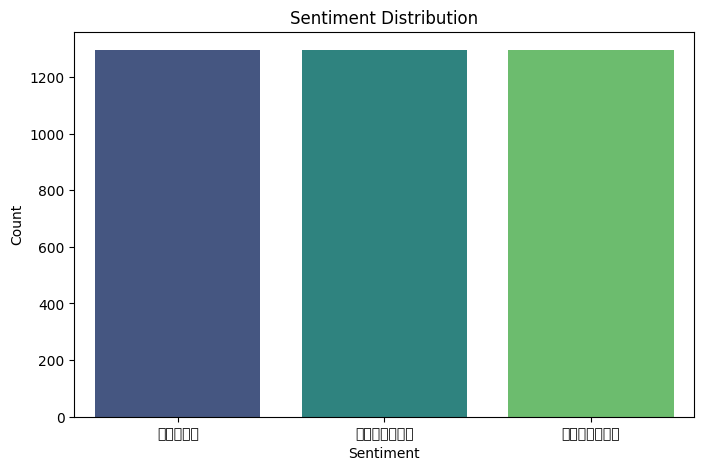

In [3]:
# sentiment distribution
sentiment_counts = data['sentiment'].value_counts()

# plotting sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [4]:
# splitting the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'], data['sentiment_numeric'], test_size=0.2, random_state=42, stratify=data['sentiment_numeric']
)

# wrapping data into Hugging Face Dataset format
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

# loading tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/3108 [00:00<?, ? examples/s]

Map:   0%|          | 0/777 [00:00<?, ? examples/s]

In [5]:
# loading pre-trained XLM-R model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# defining training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

# defining Trainer
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# training the model
trainer.train()


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-8dd4b47027b0>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.826800,0.775044,0.697555,0.694242
2,0.711100,0.704224,0.718147,0.713934
3,0.718100,0.685577,0.722008,0.718814


TrainOutput(global_step=585, training_loss=0.7794161926986825, metrics={'train_runtime': 1201.4333, 'train_samples_per_second': 7.761, 'train_steps_per_second': 0.487, 'total_flos': 2453269506895872.0, 'train_loss': 0.7794161926986825, 'epoch': 3.0})

In [6]:
# evaluating on test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# classification report
print(classification_report(test_labels, preds, target_names=["Negative", "Neutral", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.78      0.77      0.77       259
     Neutral       0.66      0.58      0.61       259
    Positive       0.72      0.82      0.77       259

    accuracy                           0.72       777
   macro avg       0.72      0.72      0.72       777
weighted avg       0.72      0.72      0.72       777



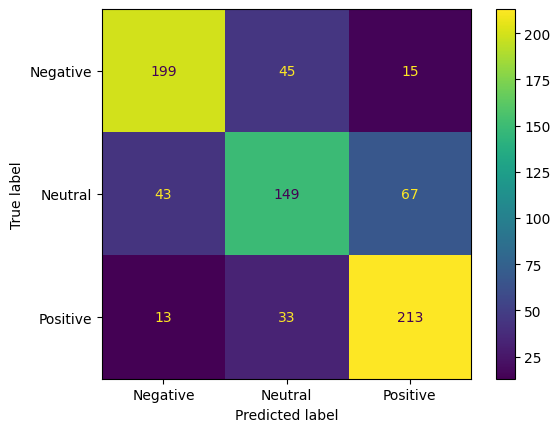

In [7]:
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

ConfusionMatrixDisplay.from_predictions(test_labels, preds, display_labels=["Negative", "Neutral", "Positive"])
plt.show()


In [9]:
#inference

import torch

def predict_sentiment_xlmr(text, model, tokenizer):
    """
    Predicting the sentiment of the input text using the trained XLM-R model.
    Args:
    - text (str): The input text in Kannada.
    - model: The trained Hugging Face XLM-R model.
    - tokenizer: The tokenizer used for preprocessing.

    Returns:
    - sentiment (str): Predicted sentiment (Negative, Neutral, Positive).
    - confidence (float): Confidence score of the prediction.
    """
    # moving model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # preprocessing the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # performing inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # getting the predicted class and confidence
    predicted_class = torch.argmax(probabilities).item()
    confidence = probabilities[0][predicted_class].item()

    # mapping numeric labels to sentiment
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = label_map[predicted_class]

    return sentiment, confidence

# taking user input
user_input = input("Enter a Kannada text: ")

# predicting sentiment
predicted_sentiment, confidence_score = predict_sentiment_xlmr(user_input, model, tokenizer)

# displaying result
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Confidence Score: {confidence_score:.2f}")


Enter a Kannada text: ನಾನು ಇಂದು ಬಹಳ ಸಂತೋಷವಾಗಿದ್ದೇನೆ
Predicted Sentiment: Positive
Confidence Score: 0.94
